In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


2022-10-21 18:38:13.194942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 18:38:13.377855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 18:38:13.377883: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-21 18:38:13.411412: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-21 18:38:14.152213: W tensorflow/stream_executor/platform/de

In [10]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

op           hi           lo  \
timestamp                 symbol                                           
2019-07-20 12:00:00+00:00 BNB        30.722500     30.77250     30.62500   
                          BTC     10564.250000  10630.00000  10525.50000   
                          ETH       225.930000    226.44000    225.51000   
                          XRP         0.327975      0.32840      0.32700   
2019-07-20 13:00:00+00:00 BNB        30.625000     30.86750     30.33500   
...                                        ...          ...          ...   
2022-10-21 09:00:00+00:00 ETH      1277.700000   1281.80000   1272.40000   
                          LINK        6.511000      6.57300      6.46150   
                          MATIC       0.797700      0.80080      0.78910   
                          SOL        27.480000     27.60000     27.20250   
                          XRP         0.439450      0.44265      0.43805   

                                            cl        volume  \
timestamp                 symbol                               
2019-07-20 12:00:00+00:00 BNB        30.625000  2.215166e+04   
                          BTC     10539.500000  1.052997e+07   
                          ETH       225.830000  0.000000e+00   
                          XRP         0.327975  0.000000e+00   
2019-07-20 13:00:00+00:00 BNB        30.562500  1.649716e+05   
...                                        ...           ...   
2022-10-21 09:00:00+00:00 ETH      1280.200000  5.035840e+07   
                          LINK        6.558000  1.082293e+06   
                          MATIC       0.796500  4.192378e+06   
                          SOL        27.540000  2.082210e+07   
                          XRP         0.442275  3.336442e+06   

                                        execution_start_at       ret  
timestamp                 symbol                                      
2019-07-20 12:00:00+00:00 BNB    2019-07-20 13:00:00+00:00 -0.020256  
                          BTC    2019-07-20 13:00:00+00:00 -0.001922  
                          ETH    2019-07-20 13:00:00+00:00 -0.011953  
                          XRP    2019-07-20 13:00:00+00:00 -0.008708  
2019-07-20 13:00:00+00:00 BNB    2019-07-20 14:00:00+00:00 -0.026494  
...                                                    ...       ...  
2022-10-21 09:00:00+00:00 ETH    2022-10-21 10:00:00+00:00       NaN  
                          LINK   2022-10-21 10:00:00+00:00       NaN  
                          MATIC  2022-10-21 10:00:00+00:00       NaN  
                          SOL    2022-10-21 10:00:00+00:00       NaN  
                          XRP    2022-10-21 10:00:00+00:00       NaN  

[257448 rows x 7 columns]

In [2]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype
import pandas_ta as ta

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7
    
    df['beta_weight'] = 1
    # df['beta_weight'] = 1 + df.groupby('symbol')['volume'].transform(lambda x: x.rolling(24 * 7, 1).mean())
    
    def beta_mean(col):
        return (df[col] * df['beta_weight']).groupby('timestamp').transform('mean') / df.groupby('timestamp')['beta_weight'].transform('mean')

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    df['beta'] = (
        (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
        / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    ).fillna(0).clip(0.1, 2.0)
    # df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = df.groupby('timestamp')['ret'].transform('mean')
        ret_mean = beta_mean('ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['Open'] = df['op']
    df['High'] = df['hi']
    df['Low'] = df['lo']
    df['Close'] = df['cl']
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]
    
    # for t in [24]:
    for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
                
                (df.ta.chop(t) / 50 - 1).fillna(0).rename('feature_chop_{}'.format(t)),
                (df.ta.entropy(t).rolling(2 * t).rank(pct=True) * 2 - 1).fillna(0).rename('feature_entropy_{}'.format(t)),
                df.ta.ttm_trend(t).iloc[:, 0].fillna(0).rename('feature_ttm_trend_{}'.format(t)),
                df.ta.vhf(t).fillna(0).rename('feature_vhf_{}'.format(t)),
                df.ta.ebsw(t).fillna(0).rename('feature_ebsw_{}'.format(t)),
                (df.ta.vortex(t).iloc[:, 0].rolling(2 * t).rank(pct=True) * 2 - 1).fillna(0).rename('feature_vtxp_{}'.format(t)),
                (df.ta.vortex(t).iloc[:, 1].rolling(2 * t).rank(pct=True) * 2 - 1).fillna(0).rename('feature_vtxm_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)

        model = clone(self.estimator)

        model.fit(X, np.arange(X.shape[0]))
        importances = model.feature_importances_

        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        features = list(range(X.shape[1]))
        feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
        feature_imp = feature_imp.sort_values('value')

        for i in range(X.shape[1] - remove_count, X.shape[1]):
            features.remove(int(feature_imp['feature'].iloc[i]))

        self.selected_features_ = np.array(features)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


In [4]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [5]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [6]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [10]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

class ExampleModelRank:
    def __init__(self, ensemble=10):
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        print('fit df.shape', df.shape)
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            patience=10,
            # patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )
        
        models = []
        for i in range(0, self.ensemble):
            callbacks = [
                es,
            ]
            if self.ensemble <= 10:
                callbacks += [tb]
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1 - 200 * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=callbacks,
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
            # models.append(['lgbm{}'.format(i), lgb.LGBMRegressor(random_state=i, n_jobs=-1)])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            ('remove_nonstationary1', NonstationaryFeatureRemover(
                estimator=nonstationary_est,
                # remove_ratio=0.1,
                remove_count=100,
            )),
            ('remove_nonstationary2', NonstationaryFeatureRemover(
                estimator=nonstationary_est,
                # remove_ratio=0.1,
                remove_count=100,
            )),
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        
        sw = np.abs(df['ret_beta'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
        
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
            
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        df = calc_features(df)
        
        return df
    
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    # act = 'elu'
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    
    def initializer(shape, dtype=None):
        p = 0.1
        dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
        # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
        # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
        w = initializers.HeNormal()(shape, dtype=dtype)
        # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
        # w = w ** 3 # 3 is good
        w /= tf.reduce_mean(w ** 2) ** 0.5
        print(shape)
        n_in, n_out = shape
        # w /= n_in ** 0.5
        # w /= n_out ** 0.5 # good
        
        # https://arxiv.org/pdf/1902.06853.pdf
        w /= n_in ** 0.5
        # w *= 1.3
        # w *= 0.9
        return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    # size = 32
    size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    depth = 2 + idx * 0
    for i in range(depth):
        t = 1.0 * i / (depth - 1)
        x_prev = x
        
        dist_reg = DistanceL2(l2_dist)
        dist_regs.append(dist_reg)
        # dense = GaussianDropConnectDense(
        dense = Dense(
            # size,
            # 32,
            # 64,
            128, # good with l2 reg
            # 256,
            # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
            # 64 if i == 0 else 128,
            activation=act, 
            # activation=None,
            use_bias=True,
            # use_bias=False,
            # kernel_regularizer=reg_l1, 
            kernel_regularizer=reg,
            # kernel_regularizer=dist_reg,
            # kernel_regularizer=reg2,
            bias_regularizer=reg,
            # kernel_initializer='zeros' if i > 0 else initializer,
            kernel_initializer=initializer, 
            bias_initializer=bias_initializer,
            # kernel_constraint=mars_constraint,
            # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
        )
        dist_reg_layers.append(dense)
        # dense = GaussianDropConnect(dense, rate=0.2)
        x = dense(x)
        # x = BatchNormalization()(x)
        # def smooth_units(x):
        #     return (x[:, 1:] + x[:, :-1]) / 2
        #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
        # x = Lambda(smooth_units)(x)
        # x = Activation(act)(x)
        # x = Lambda(smooth_units)(x)
        # if i > 0:
        #     x = Add()([x, x_prev])
        # if i == 9:
        #     x = tf.keras.layers.GaussianDropout(0.5)(x)
        # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
        # x = Dropout(dropout_rate)(x)
        # x = Dropout(0.1)(x)
        # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
        hidden_outputs.append(x)


    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1, 
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    # opt = Nadam(
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.002,
    #     beta_1=0.9, 
    #     # beta_1=0.5,
    #     # beta_2=0.9,
    #     beta_2=0.999,
    #     epsilon=None,
    #     # epsilon=1e-1,
    #     # epsilon=1e-3,
    #     schedule_decay=0.004,
    # )
    opt = tfa.optimizers.AdaBelief(
        # learning_rate=0.001,
        learning_rate=0.001 / 8,
        # learning_rate=0.001 / 8 / 8,
        # learning_rate=0.001 / 8 / 8 / 8,
        # total_steps=1200,
        # warmup_proportion=0.1,
        # min_lr=1e-5,
        # rectify=True,
        # weight_decay=1e-2,
        # weight_decay=1e-3,
        # epsilon=1e-10,
    )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     # learning_rate=0.002,
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

fit df.shape (220740, 881)
[661, 128]
[128, 128]
[128, 1]
Epoch 1/1000
38/38 - 3s - loss: 1.1515 - mse: 1.0000 - weighted_mse: 0.9989 - cosine_similarity: 0.0429 - val_loss: 0.6434 - val_mse: 1.0001 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0225 - 3s/epoch - 77ms/step
Epoch 2/1000
38/38 - 2s - loss: 1.1488 - mse: 0.9990 - weighted_mse: 0.9966 - cosine_similarity: 0.0851 - val_loss: 0.6432 - val_mse: 1.0002 - val_weighted_mse: 0.9994 - val_cosine_similarity: 0.0301 - 2s/epoch - 50ms/step
Epoch 3/1000
38/38 - 1s - loss: 1.1444 - mse: 0.9976 - weighted_mse: 0.9928 - cosine_similarity: 0.1048 - val_loss: 0.6430 - val_mse: 1.0004 - val_weighted_mse: 0.9991 - val_cosine_similarity: 0.0272 - 1s/epoch - 29ms/step
Epoch 4/1000
38/38 - 2s - loss: 1.1390 - mse: 0.9955 - weighted_mse: 0.9881 - cosine_similarity: 0.1141 - val_loss: 0.6429 - val_mse: 1.0007 - val_weighted_mse: 0.9989 - val_cosine_similarity: 0.0254 - 2s/epoch - 56ms/step
Epoch 5/1000
38/38 - 1s - loss: 1.1337 - mse: 0.99

INFO:tensorflow:Assets written to: /tmp/tmpwbnoy_bp/assets
2022-10-21 19:05:46.945013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:46.945072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:46.946380: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwbnoy_bp
2022-10-21 19:05:46.947718: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:46.947739: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwbnoy_bp
2022-10-21 19:05:46.955813: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:47.004087: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwbnoy_bp
2022-10-21 19:05:47.018644: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr7r0wphr/assets


INFO:tensorflow:Assets written to: /tmp/tmpr7r0wphr/assets
2022-10-21 19:05:48.186006: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:48.186062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:48.186212: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr7r0wphr
2022-10-21 19:05:48.187545: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:48.187568: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr7r0wphr
2022-10-21 19:05:48.192194: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:48.244535: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr7r0wphr
2022-10-21 19:05:48.257078: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyzjunp94/assets


INFO:tensorflow:Assets written to: /tmp/tmpyzjunp94/assets
2022-10-21 19:05:49.373634: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:49.373695: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:49.373876: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyzjunp94
2022-10-21 19:05:49.375157: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:49.375179: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyzjunp94
2022-10-21 19:05:49.383223: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:49.429974: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyzjunp94
2022-10-21 19:05:49.440253: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplzjvjjc_/assets


INFO:tensorflow:Assets written to: /tmp/tmplzjvjjc_/assets
2022-10-21 19:05:50.585941: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:50.585995: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:50.586133: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplzjvjjc_
2022-10-21 19:05:50.587410: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:50.587430: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplzjvjjc_
2022-10-21 19:05:50.591602: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:50.644058: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplzjvjjc_
2022-10-21 19:05:50.654342: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9p7cjdqw/assets


INFO:tensorflow:Assets written to: /tmp/tmp9p7cjdqw/assets
2022-10-21 19:05:51.795605: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:51.795665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:51.795837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9p7cjdqw
2022-10-21 19:05:51.797112: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:51.797134: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9p7cjdqw
2022-10-21 19:05:51.803406: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:51.850142: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9p7cjdqw
2022-10-21 19:05:51.860460: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpave26u26/assets


INFO:tensorflow:Assets written to: /tmp/tmpave26u26/assets
2022-10-21 19:05:53.016817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:53.016880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:53.017074: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpave26u26
2022-10-21 19:05:53.018340: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:53.018361: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpave26u26
2022-10-21 19:05:53.023765: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:53.071265: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpave26u26
2022-10-21 19:05:53.081259: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyyf34j2a/assets


INFO:tensorflow:Assets written to: /tmp/tmpyyf34j2a/assets
2022-10-21 19:05:54.219878: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:54.219940: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:54.220110: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyyf34j2a
2022-10-21 19:05:54.221413: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:54.221435: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyyf34j2a
2022-10-21 19:05:54.226598: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:54.273494: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyyf34j2a
2022-10-21 19:05:54.283779: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcj6ektke/assets


INFO:tensorflow:Assets written to: /tmp/tmpcj6ektke/assets
2022-10-21 19:05:55.422518: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:55.422567: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:55.422707: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcj6ektke
2022-10-21 19:05:55.424018: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:55.424039: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcj6ektke
2022-10-21 19:05:55.428445: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:55.485157: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcj6ektke
2022-10-21 19:05:55.495655: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu_trknuu/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_trknuu/assets
2022-10-21 19:05:56.652055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:56.652110: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:56.652251: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu_trknuu
2022-10-21 19:05:56.653510: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:56.653531: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu_trknuu
2022-10-21 19:05:56.657786: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:56.702720: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu_trknuu
2022-10-21 19:05:56.712843: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjbgojtt6/assets


INFO:tensorflow:Assets written to: /tmp/tmpjbgojtt6/assets
2022-10-21 19:05:57.864403: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:05:57.864460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:05:57.864603: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjbgojtt6
2022-10-21 19:05:57.865859: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:05:57.865880: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjbgojtt6
2022-10-21 19:05:57.870240: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:05:57.917440: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjbgojtt6
2022-10-21 19:05:57.927839: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

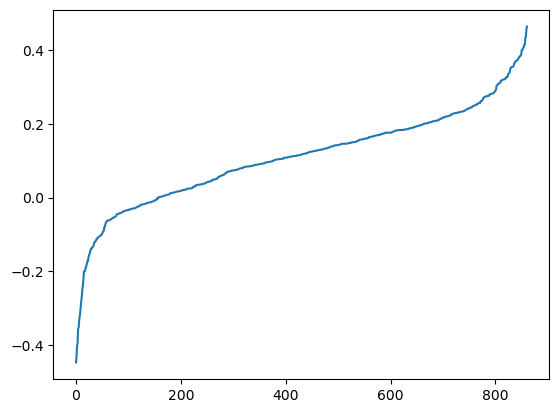

fit df.shape (206762, 881)
[661, 128]
[128, 128]
[128, 1]
Epoch 1/1000
36/36 - 4s - loss: 1.1561 - mse: 1.0003 - weighted_mse: 0.9988 - cosine_similarity: 0.0511 - val_loss: 0.6325 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0180 - 4s/epoch - 106ms/step
Epoch 2/1000
36/36 - 1s - loss: 1.1542 - mse: 0.9996 - weighted_mse: 0.9972 - cosine_similarity: 0.0936 - val_loss: 0.6324 - val_mse: 1.0004 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0239 - 1s/epoch - 29ms/step
Epoch 3/1000
36/36 - 1s - loss: 1.1511 - mse: 0.9985 - weighted_mse: 0.9945 - cosine_similarity: 0.1081 - val_loss: 0.6323 - val_mse: 1.0006 - val_weighted_mse: 0.9995 - val_cosine_similarity: 0.0277 - 1s/epoch - 29ms/step
Epoch 4/1000
36/36 - 1s - loss: 1.1471 - mse: 0.9970 - weighted_mse: 0.9911 - cosine_similarity: 0.1128 - val_loss: 0.6322 - val_mse: 1.0008 - val_weighted_mse: 0.9993 - val_cosine_similarity: 0.0272 - 1s/epoch - 31ms/step
Epoch 5/1000
36/36 - 1s - loss: 1.1425 - mse: 0.9

INFO:tensorflow:Assets written to: /tmp/tmpqp140qaz/assets
2022-10-21 19:13:28.457513: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:28.457570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:28.457712: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqp140qaz
2022-10-21 19:13:28.459040: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:28.459060: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqp140qaz
2022-10-21 19:13:28.463601: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:28.512330: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqp140qaz
2022-10-21 19:13:28.522967: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp810o6r6l/assets


INFO:tensorflow:Assets written to: /tmp/tmp810o6r6l/assets
2022-10-21 19:13:29.673453: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:29.673511: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:29.673658: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp810o6r6l
2022-10-21 19:13:29.674977: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:29.675000: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp810o6r6l
2022-10-21 19:13:29.679329: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:29.726295: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp810o6r6l
2022-10-21 19:13:29.736615: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt7x9s0im/assets


INFO:tensorflow:Assets written to: /tmp/tmpt7x9s0im/assets
2022-10-21 19:13:30.866372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:30.866435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:30.866596: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt7x9s0im
2022-10-21 19:13:30.867957: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:30.867998: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt7x9s0im
2022-10-21 19:13:30.872852: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:30.919520: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt7x9s0im
2022-10-21 19:13:30.929901: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp60kqzi7k/assets


INFO:tensorflow:Assets written to: /tmp/tmp60kqzi7k/assets
2022-10-21 19:13:32.043077: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:32.043134: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:32.043304: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp60kqzi7k
2022-10-21 19:13:32.044576: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:32.044597: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp60kqzi7k
2022-10-21 19:13:32.049108: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:32.094681: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp60kqzi7k
2022-10-21 19:13:32.104940: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps3qr1a_d/assets


INFO:tensorflow:Assets written to: /tmp/tmps3qr1a_d/assets
2022-10-21 19:13:33.207164: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:33.207245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:33.207389: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps3qr1a_d
2022-10-21 19:13:33.208700: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:33.208721: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps3qr1a_d
2022-10-21 19:13:33.213050: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:33.258095: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps3qr1a_d
2022-10-21 19:13:33.268047: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8m2nbztv/assets


INFO:tensorflow:Assets written to: /tmp/tmp8m2nbztv/assets
2022-10-21 19:13:34.358783: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:34.358838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:34.359005: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8m2nbztv
2022-10-21 19:13:34.360255: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:34.360276: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8m2nbztv
2022-10-21 19:13:34.364629: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:34.410122: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8m2nbztv
2022-10-21 19:13:34.420378: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb48wd7gx/assets


INFO:tensorflow:Assets written to: /tmp/tmpb48wd7gx/assets
2022-10-21 19:13:35.518126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:35.518187: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:35.518370: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb48wd7gx
2022-10-21 19:13:35.519683: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:35.519705: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb48wd7gx
2022-10-21 19:13:35.523972: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:35.568847: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb48wd7gx
2022-10-21 19:13:35.579231: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbyz_c3sz/assets


INFO:tensorflow:Assets written to: /tmp/tmpbyz_c3sz/assets
2022-10-21 19:13:36.688323: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:36.688388: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:36.688536: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbyz_c3sz
2022-10-21 19:13:36.689823: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:36.689844: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbyz_c3sz
2022-10-21 19:13:36.694138: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:36.738956: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbyz_c3sz
2022-10-21 19:13:36.749114: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpin8p_bas/assets


INFO:tensorflow:Assets written to: /tmp/tmpin8p_bas/assets
2022-10-21 19:13:37.858481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:37.858541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:37.858683: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpin8p_bas
2022-10-21 19:13:37.859958: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:37.859980: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpin8p_bas
2022-10-21 19:13:37.864379: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:37.910259: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpin8p_bas
2022-10-21 19:13:37.920478: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvm7k6w6o/assets


INFO:tensorflow:Assets written to: /tmp/tmpvm7k6w6o/assets
2022-10-21 19:13:39.002335: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:13:39.002390: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:13:39.002529: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvm7k6w6o
2022-10-21 19:13:39.003790: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:13:39.003810: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvm7k6w6o
2022-10-21 19:13:39.008159: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:13:39.053899: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvm7k6w6o
2022-10-21 19:13:39.064244: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

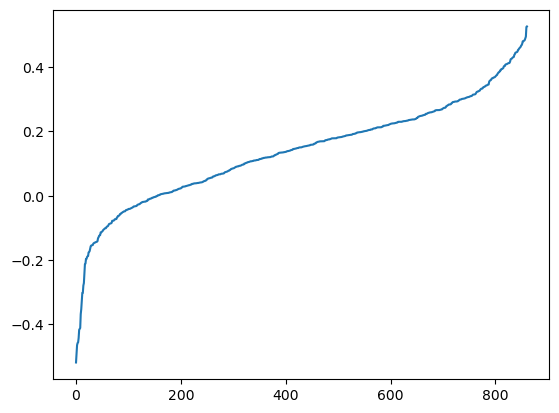

fit df.shape (199624, 881)
[661, 128]
[128, 128]
[128, 1]
Epoch 1/1000
35/35 - 4s - loss: 1.0979 - mse: 1.0000 - weighted_mse: 0.9992 - cosine_similarity: 0.0445 - val_loss: 0.7696 - val_mse: 1.0000 - val_weighted_mse: 0.9999 - val_cosine_similarity: 0.0149 - 4s/epoch - 125ms/step
Epoch 2/1000
35/35 - 1s - loss: 1.0962 - mse: 0.9996 - weighted_mse: 0.9976 - cosine_similarity: 0.0872 - val_loss: 0.7695 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0116 - 1s/epoch - 34ms/step
Epoch 3/1000
35/35 - 1s - loss: 1.0936 - mse: 0.9989 - weighted_mse: 0.9953 - cosine_similarity: 0.1098 - val_loss: 0.7695 - val_mse: 1.0006 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0097 - 1s/epoch - 34ms/step
Epoch 4/1000
35/35 - 1s - loss: 1.0904 - mse: 0.9983 - weighted_mse: 0.9924 - cosine_similarity: 0.1133 - val_loss: 0.7695 - val_mse: 1.0010 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0096 - 1s/epoch - 36ms/step
Epoch 5/1000
35/35 - 1s - loss: 1.0868 - mse: 0.9

INFO:tensorflow:Assets written to: /tmp/tmp64w2g2i9/assets
2022-10-21 19:20:13.651612: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:13.651678: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:13.651844: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp64w2g2i9
2022-10-21 19:20:13.653402: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:13.653426: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp64w2g2i9
2022-10-21 19:20:13.658579: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:13.715814: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp64w2g2i9
2022-10-21 19:20:13.728177: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiw7j7jbh/assets


INFO:tensorflow:Assets written to: /tmp/tmpiw7j7jbh/assets
2022-10-21 19:20:15.067966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:15.068027: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:15.068186: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiw7j7jbh
2022-10-21 19:20:15.069699: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:15.069724: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiw7j7jbh
2022-10-21 19:20:15.074827: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:15.130211: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiw7j7jbh
2022-10-21 19:20:15.142146: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjxhzgtnj/assets


INFO:tensorflow:Assets written to: /tmp/tmpjxhzgtnj/assets
2022-10-21 19:20:16.887163: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:16.887224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:16.887384: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjxhzgtnj
2022-10-21 19:20:16.888890: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:16.888916: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjxhzgtnj
2022-10-21 19:20:16.893736: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:16.945934: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjxhzgtnj
2022-10-21 19:20:16.957367: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvqdw2w0w/assets


INFO:tensorflow:Assets written to: /tmp/tmpvqdw2w0w/assets
2022-10-21 19:20:18.178757: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:18.178816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:18.179022: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvqdw2w0w
2022-10-21 19:20:18.180444: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:18.180466: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvqdw2w0w
2022-10-21 19:20:18.185216: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:18.236758: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvqdw2w0w
2022-10-21 19:20:18.248289: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2edfi9df/assets


INFO:tensorflow:Assets written to: /tmp/tmp2edfi9df/assets
2022-10-21 19:20:19.450050: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:19.450106: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:19.450288: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2edfi9df
2022-10-21 19:20:19.451653: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:19.451675: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2edfi9df
2022-10-21 19:20:19.456225: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:19.506868: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2edfi9df
2022-10-21 19:20:19.518188: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpij9jhwmf/assets


INFO:tensorflow:Assets written to: /tmp/tmpij9jhwmf/assets
2022-10-21 19:20:20.682270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:20.682324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:20.682473: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpij9jhwmf
2022-10-21 19:20:20.683835: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:20.683857: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpij9jhwmf
2022-10-21 19:20:20.688479: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:20.737621: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpij9jhwmf
2022-10-21 19:20:20.748560: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpty0vn7px/assets


INFO:tensorflow:Assets written to: /tmp/tmpty0vn7px/assets
2022-10-21 19:20:21.875617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:21.875672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:21.875815: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpty0vn7px
2022-10-21 19:20:21.877138: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:21.877160: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpty0vn7px
2022-10-21 19:20:21.881619: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:21.929722: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpty0vn7px
2022-10-21 19:20:21.940370: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp17b41xf/assets


INFO:tensorflow:Assets written to: /tmp/tmpp17b41xf/assets
2022-10-21 19:20:23.063582: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:23.063640: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:23.063786: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp17b41xf
2022-10-21 19:20:23.065157: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:23.065181: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp17b41xf
2022-10-21 19:20:23.069541: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:23.116052: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp17b41xf
2022-10-21 19:20:23.126524: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_g0eecdf/assets


INFO:tensorflow:Assets written to: /tmp/tmp_g0eecdf/assets
2022-10-21 19:20:24.231356: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:24.231409: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:24.231548: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_g0eecdf
2022-10-21 19:20:24.232827: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:24.232847: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_g0eecdf
2022-10-21 19:20:24.237179: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:24.283178: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_g0eecdf
2022-10-21 19:20:24.293238: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu2h_m6cl/assets


INFO:tensorflow:Assets written to: /tmp/tmpu2h_m6cl/assets
2022-10-21 19:20:25.357323: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:20:25.357376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:20:25.357525: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu2h_m6cl
2022-10-21 19:20:25.358898: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:20:25.358918: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu2h_m6cl
2022-10-21 19:20:25.363409: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:20:25.408657: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu2h_m6cl
2022-10-21 19:20:25.418787: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

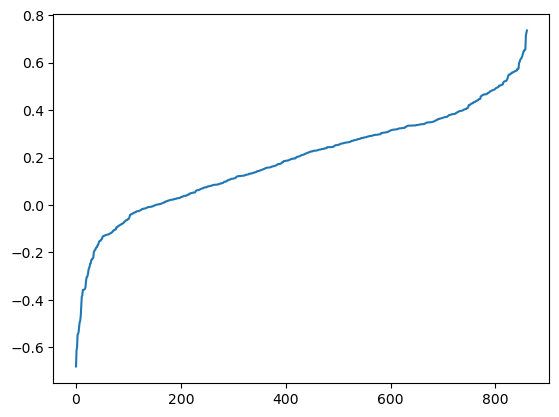

fit df.shape (199624, 881)
[661, 128]
[128, 128]
[128, 1]
Epoch 1/1000
35/35 - 4s - loss: 1.1401 - mse: 1.0002 - weighted_mse: 0.9994 - cosine_similarity: 0.0273 - val_loss: 0.6715 - val_mse: 1.0001 - val_weighted_mse: 0.9999 - val_cosine_similarity: 0.0060 - 4s/epoch - 119ms/step
Epoch 2/1000
35/35 - 1s - loss: 1.1379 - mse: 0.9998 - weighted_mse: 0.9975 - cosine_similarity: 0.0863 - val_loss: 0.6713 - val_mse: 1.0003 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0237 - 1s/epoch - 32ms/step
Epoch 3/1000
35/35 - 1s - loss: 1.1343 - mse: 0.9990 - weighted_mse: 0.9944 - cosine_similarity: 0.1105 - val_loss: 0.6711 - val_mse: 1.0004 - val_weighted_mse: 0.9994 - val_cosine_similarity: 0.0237 - 1s/epoch - 41ms/step
Epoch 4/1000
35/35 - 2s - loss: 1.1297 - mse: 0.9979 - weighted_mse: 0.9903 - cosine_similarity: 0.1164 - val_loss: 0.6709 - val_mse: 1.0005 - val_weighted_mse: 0.9990 - val_cosine_similarity: 0.0268 - 2s/epoch - 46ms/step
Epoch 5/1000
35/35 - 1s - loss: 1.1245 - mse: 0.9

INFO:tensorflow:Assets written to: /tmp/tmp89j_x0gv/assets
2022-10-21 19:27:39.169678: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:39.169744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:39.169909: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp89j_x0gv
2022-10-21 19:27:39.171528: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:39.171553: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp89j_x0gv
2022-10-21 19:27:39.176960: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:39.233754: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp89j_x0gv
2022-10-21 19:27:39.246032: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzohtw_0z/assets


INFO:tensorflow:Assets written to: /tmp/tmpzohtw_0z/assets
2022-10-21 19:27:40.582446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:40.582509: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:40.582710: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzohtw_0z
2022-10-21 19:27:40.584204: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:40.584228: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzohtw_0z
2022-10-21 19:27:40.589298: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:40.643776: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzohtw_0z
2022-10-21 19:27:40.655653: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiwhz5uyr/assets


INFO:tensorflow:Assets written to: /tmp/tmpiwhz5uyr/assets
2022-10-21 19:27:41.953066: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:41.953128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:41.953284: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiwhz5uyr
2022-10-21 19:27:41.954737: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:41.954760: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiwhz5uyr
2022-10-21 19:27:41.959626: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:42.012287: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiwhz5uyr
2022-10-21 19:27:42.024180: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz56asdwm/assets


INFO:tensorflow:Assets written to: /tmp/tmpz56asdwm/assets
2022-10-21 19:27:43.278156: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:43.278215: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:43.278367: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz56asdwm
2022-10-21 19:27:43.279787: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:43.279809: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz56asdwm
2022-10-21 19:27:43.284520: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:43.335674: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz56asdwm
2022-10-21 19:27:43.346812: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmg0fxcl7/assets


INFO:tensorflow:Assets written to: /tmp/tmpmg0fxcl7/assets
2022-10-21 19:27:44.521131: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:44.521186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:44.521332: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmg0fxcl7
2022-10-21 19:27:44.522693: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:44.522715: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmg0fxcl7
2022-10-21 19:27:44.527248: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:44.576791: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmg0fxcl7
2022-10-21 19:27:44.587543: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4yekh402/assets


INFO:tensorflow:Assets written to: /tmp/tmp4yekh402/assets
2022-10-21 19:27:45.769133: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:45.769189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:45.769333: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4yekh402
2022-10-21 19:27:45.770679: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:45.770702: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4yekh402
2022-10-21 19:27:45.775175: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:45.823090: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4yekh402
2022-10-21 19:27:45.833631: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxp6myf84/assets


INFO:tensorflow:Assets written to: /tmp/tmpxp6myf84/assets
2022-10-21 19:27:46.960580: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:46.960657: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:46.960797: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxp6myf84
2022-10-21 19:27:46.962123: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:46.962144: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxp6myf84
2022-10-21 19:27:46.966421: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:47.013288: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxp6myf84
2022-10-21 19:27:47.023269: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj3dqw4eu/assets


INFO:tensorflow:Assets written to: /tmp/tmpj3dqw4eu/assets
2022-10-21 19:27:48.280253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:48.280298: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:48.280435: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj3dqw4eu
2022-10-21 19:27:48.281715: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:48.281736: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj3dqw4eu
2022-10-21 19:27:48.286078: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:48.331957: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj3dqw4eu
2022-10-21 19:27:48.342339: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp60ovi2ox/assets


INFO:tensorflow:Assets written to: /tmp/tmp60ovi2ox/assets
2022-10-21 19:27:49.421019: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:49.421061: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:49.421192: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp60ovi2ox
2022-10-21 19:27:49.422453: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:49.422474: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp60ovi2ox
2022-10-21 19:27:49.426668: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:49.472010: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp60ovi2ox
2022-10-21 19:27:49.481937: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw4_2jh4d/assets


INFO:tensorflow:Assets written to: /tmp/tmpw4_2jh4d/assets
2022-10-21 19:27:50.549081: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:27:50.549153: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:27:50.549285: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw4_2jh4d
2022-10-21 19:27:50.550535: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:27:50.550556: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw4_2jh4d
2022-10-21 19:27:50.554804: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:27:50.599600: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw4_2jh4d
2022-10-21 19:27:50.609670: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

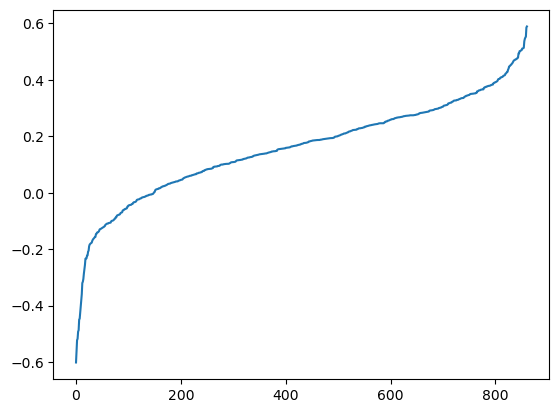

fit df.shape (200128, 881)
[661, 128]
[128, 128]
[128, 1]
Epoch 1/1000
35/35 - 4s - loss: 1.0623 - mse: 1.0001 - weighted_mse: 0.9996 - cosine_similarity: 0.0229 - val_loss: 0.8532 - val_mse: 0.9997 - val_weighted_mse: 0.9992 - val_cosine_similarity: 0.0770 - 4s/epoch - 118ms/step
Epoch 2/1000
35/35 - 1s - loss: 1.0601 - mse: 0.9995 - weighted_mse: 0.9976 - cosine_similarity: 0.0870 - val_loss: 0.8524 - val_mse: 0.9993 - val_weighted_mse: 0.9983 - val_cosine_similarity: 0.0890 - 1s/epoch - 34ms/step
Epoch 3/1000
35/35 - 1s - loss: 1.0564 - mse: 0.9985 - weighted_mse: 0.9942 - cosine_similarity: 0.1108 - val_loss: 0.8513 - val_mse: 0.9985 - val_weighted_mse: 0.9970 - val_cosine_similarity: 0.0930 - 1s/epoch - 35ms/step
Epoch 4/1000
35/35 - 2s - loss: 1.0517 - mse: 0.9973 - weighted_mse: 0.9898 - cosine_similarity: 0.1158 - val_loss: 0.8499 - val_mse: 0.9971 - val_weighted_mse: 0.9953 - val_cosine_similarity: 0.0927 - 2s/epoch - 45ms/step
Epoch 5/1000
35/35 - 1s - loss: 1.0465 - mse: 0.9

INFO:tensorflow:Assets written to: /tmp/tmpn9fwiimn/assets
2022-10-21 19:36:53.394875: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:36:53.394948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:36:53.395132: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn9fwiimn
2022-10-21 19:36:53.396908: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:36:53.396937: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn9fwiimn
2022-10-21 19:36:53.402754: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:36:53.465223: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn9fwiimn
2022-10-21 19:36:53.479462: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpestaimnq/assets


INFO:tensorflow:Assets written to: /tmp/tmpestaimnq/assets
2022-10-21 19:36:54.984777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:36:54.984845: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:36:54.985021: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpestaimnq
2022-10-21 19:36:54.986718: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:36:54.986745: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpestaimnq
2022-10-21 19:36:54.992391: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:36:55.052871: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpestaimnq
2022-10-21 19:36:55.066414: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_5_z9mi1/assets


INFO:tensorflow:Assets written to: /tmp/tmp_5_z9mi1/assets
2022-10-21 19:36:56.532169: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:36:56.532241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:36:56.532418: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_5_z9mi1
2022-10-21 19:36:56.534079: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:36:56.534107: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_5_z9mi1
2022-10-21 19:36:56.539613: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:36:56.598994: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_5_z9mi1
2022-10-21 19:36:56.612168: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_gzr3q5w/assets


INFO:tensorflow:Assets written to: /tmp/tmp_gzr3q5w/assets
2022-10-21 19:36:57.961896: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:36:57.961958: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:36:57.962120: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_gzr3q5w
2022-10-21 19:36:57.963653: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:36:57.963678: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_gzr3q5w
2022-10-21 19:36:57.968695: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:36:58.023207: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_gzr3q5w
2022-10-21 19:36:58.035373: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsvdb8z8s/assets


INFO:tensorflow:Assets written to: /tmp/tmpsvdb8z8s/assets
2022-10-21 19:36:59.347024: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:36:59.347089: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:36:59.347250: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsvdb8z8s
2022-10-21 19:36:59.348777: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:36:59.348802: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsvdb8z8s
2022-10-21 19:36:59.353804: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:36:59.407802: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsvdb8z8s
2022-10-21 19:36:59.420120: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphzxo1cpa/assets


INFO:tensorflow:Assets written to: /tmp/tmphzxo1cpa/assets
2022-10-21 19:37:00.684955: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:37:00.685014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:37:00.685168: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphzxo1cpa
2022-10-21 19:37:00.686612: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:37:00.686636: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphzxo1cpa
2022-10-21 19:37:00.691321: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:37:00.745816: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphzxo1cpa
2022-10-21 19:37:00.757347: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqm72zr36/assets


INFO:tensorflow:Assets written to: /tmp/tmpqm72zr36/assets
2022-10-21 19:37:01.980055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:37:01.980116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:37:01.980266: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqm72zr36
2022-10-21 19:37:01.981671: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:37:01.981695: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqm72zr36
2022-10-21 19:37:01.986275: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:37:02.042885: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqm72zr36
2022-10-21 19:37:02.054294: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp93h9wb3u/assets


INFO:tensorflow:Assets written to: /tmp/tmp93h9wb3u/assets
2022-10-21 19:37:03.250882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:37:03.250942: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:37:03.251094: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp93h9wb3u
2022-10-21 19:37:03.252518: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:37:03.252540: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp93h9wb3u
2022-10-21 19:37:03.257254: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:37:03.307007: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp93h9wb3u
2022-10-21 19:37:03.318245: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4yjo6psn/assets


INFO:tensorflow:Assets written to: /tmp/tmp4yjo6psn/assets
2022-10-21 19:37:04.499267: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:37:04.499316: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:37:04.499461: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4yjo6psn
2022-10-21 19:37:04.500831: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:37:04.500854: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4yjo6psn
2022-10-21 19:37:04.505466: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:37:04.554145: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4yjo6psn
2022-10-21 19:37:04.565087: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkpj7hy1l/assets


INFO:tensorflow:Assets written to: /tmp/tmpkpj7hy1l/assets
2022-10-21 19:37:05.706178: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 19:37:05.706235: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 19:37:05.706379: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkpj7hy1l
2022-10-21 19:37:05.707708: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 19:37:05.707730: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkpj7hy1l
2022-10-21 19:37:05.714197: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 19:37:05.763491: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkpj7hy1l
2022-10-21 19:37:05.773918: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

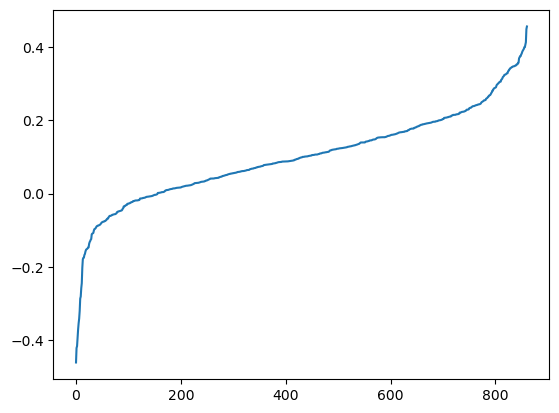

return without cost statistics
mean 0.004260208771166073
std 0.018133308295236836
sharpe 0.234938308101513
double sharpe 1.275892671638588
max drawdown 0.368650977493827
return with cost statistics
mean 0.003070719345900156
std 0.018142874740438592
sharpe 0.16925208324653426
double sharpe 0.6981076076869785
max drawdown 0.36792770465622315


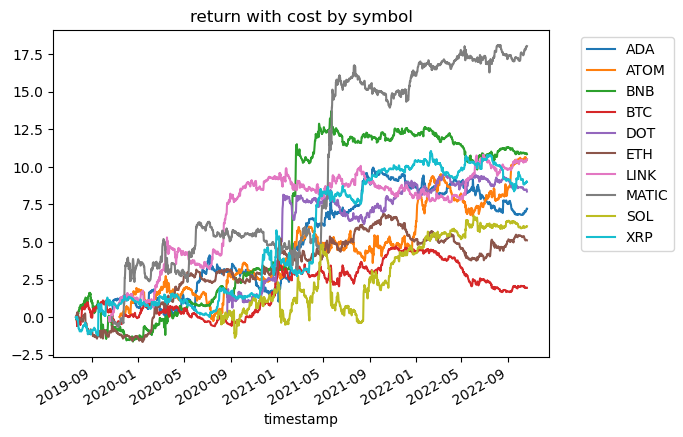

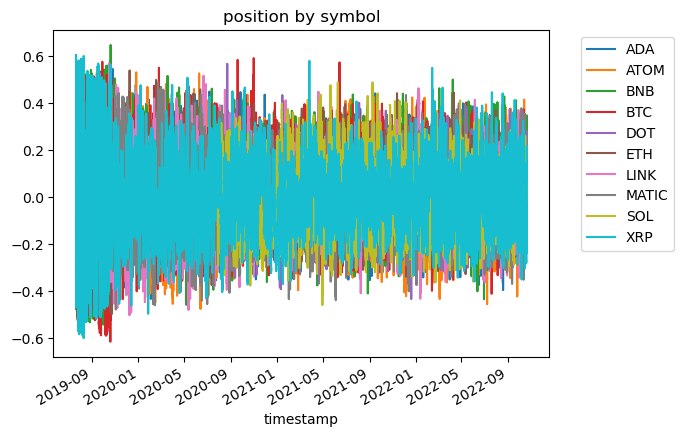

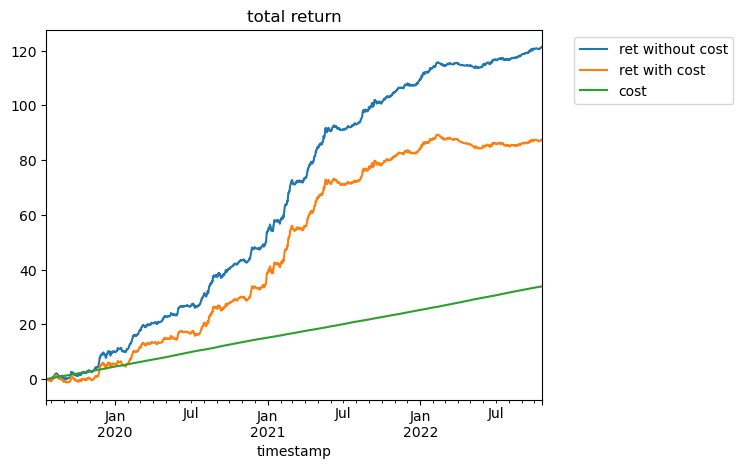

fit df.shape (257204, 881)
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[128, 128]
[128, 1]
[661, 128]
[

INFO:tensorflow:Assets written to: /tmp/tmpetp7knw9/assets
2022-10-21 20:36:48.829038: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:36:48.829105: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:36:48.829312: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpetp7knw9
2022-10-21 20:36:48.831012: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:36:48.831040: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpetp7knw9
2022-10-21 20:36:48.837622: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:36:48.902071: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpetp7knw9
2022-10-21 20:36:48.914971: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi_wgztn2/assets


INFO:tensorflow:Assets written to: /tmp/tmpi_wgztn2/assets
2022-10-21 20:36:50.320921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:36:50.320987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:36:50.321153: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi_wgztn2
2022-10-21 20:36:50.322731: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:36:50.322756: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi_wgztn2
2022-10-21 20:36:50.329142: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:36:50.397454: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi_wgztn2
2022-10-21 20:36:50.410002: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkw14sdu_/assets


INFO:tensorflow:Assets written to: /tmp/tmpkw14sdu_/assets
2022-10-21 20:36:51.735985: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:36:51.736046: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:36:51.736205: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkw14sdu_
2022-10-21 20:36:51.737822: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:36:51.737850: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkw14sdu_
2022-10-21 20:36:51.744137: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:36:51.800884: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkw14sdu_
2022-10-21 20:36:51.813247: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7rdpik5d/assets


INFO:tensorflow:Assets written to: /tmp/tmp7rdpik5d/assets
2022-10-21 20:36:53.096940: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:36:53.097000: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:36:53.097155: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7rdpik5d
2022-10-21 20:36:53.098662: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:36:53.098686: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7rdpik5d
2022-10-21 20:36:53.104722: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:36:53.160824: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7rdpik5d
2022-10-21 20:36:53.172458: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7mzbbfdz/assets


INFO:tensorflow:Assets written to: /tmp/tmp7mzbbfdz/assets
2022-10-21 20:36:54.417888: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:36:54.417942: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:36:54.418091: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7mzbbfdz
2022-10-21 20:36:54.419514: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:36:54.419536: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7mzbbfdz
2022-10-21 20:36:54.425271: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:36:54.479901: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7mzbbfdz
2022-10-21 20:36:54.490994: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprvo0ycxs/assets


INFO:tensorflow:Assets written to: /tmp/tmprvo0ycxs/assets
2022-10-21 20:36:56.487587: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:36:56.487645: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:36:56.487826: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprvo0ycxs
2022-10-21 20:36:56.489200: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:36:56.489223: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprvo0ycxs
2022-10-21 20:36:56.494785: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:36:56.549986: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprvo0ycxs
2022-10-21 20:36:56.560579: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp766vusdl/assets


INFO:tensorflow:Assets written to: /tmp/tmp766vusdl/assets
2022-10-21 20:36:57.731059: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:36:57.731116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:36:57.731262: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp766vusdl
2022-10-21 20:36:57.732623: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:36:57.732645: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp766vusdl
2022-10-21 20:36:57.738146: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:36:57.790474: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp766vusdl
2022-10-21 20:36:57.800967: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6wm6ywvh/assets


INFO:tensorflow:Assets written to: /tmp/tmp6wm6ywvh/assets
2022-10-21 20:36:58.903537: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:36:58.903614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:36:58.903759: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6wm6ywvh
2022-10-21 20:36:58.905097: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:36:58.905120: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6wm6ywvh
2022-10-21 20:36:58.910489: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:36:58.959852: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6wm6ywvh
2022-10-21 20:36:58.970042: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkihkkv4x/assets


INFO:tensorflow:Assets written to: /tmp/tmpkihkkv4x/assets
2022-10-21 20:37:00.123433: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:00.123489: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:00.123667: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkihkkv4x
2022-10-21 20:37:00.125015: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:00.125036: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkihkkv4x
2022-10-21 20:37:00.130425: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:00.177262: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkihkkv4x
2022-10-21 20:37:00.187252: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd8dx2e8c/assets


INFO:tensorflow:Assets written to: /tmp/tmpd8dx2e8c/assets
2022-10-21 20:37:01.289503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:01.289563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:01.289739: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd8dx2e8c
2022-10-21 20:37:01.291060: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:01.291081: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd8dx2e8c
2022-10-21 20:37:01.296333: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:01.350725: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd8dx2e8c
2022-10-21 20:37:01.361317: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4qr92d8t/assets


INFO:tensorflow:Assets written to: /tmp/tmp4qr92d8t/assets
2022-10-21 20:37:02.451501: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:02.451556: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:02.451718: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4qr92d8t
2022-10-21 20:37:02.453015: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:02.453036: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4qr92d8t
2022-10-21 20:37:02.458301: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:02.511232: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4qr92d8t
2022-10-21 20:37:02.521359: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdncd0p_i/assets


INFO:tensorflow:Assets written to: /tmp/tmpdncd0p_i/assets
2022-10-21 20:37:03.614047: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:03.614100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:03.614237: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdncd0p_i
2022-10-21 20:37:03.615543: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:03.615564: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdncd0p_i
2022-10-21 20:37:03.620954: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:03.670441: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdncd0p_i
2022-10-21 20:37:03.681094: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb_4bue4v/assets


INFO:tensorflow:Assets written to: /tmp/tmpb_4bue4v/assets
2022-10-21 20:37:04.774595: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:04.774652: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:04.774818: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb_4bue4v
2022-10-21 20:37:04.776148: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:04.776169: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb_4bue4v
2022-10-21 20:37:04.781443: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:04.828631: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb_4bue4v
2022-10-21 20:37:04.838562: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp85okfp66/assets


INFO:tensorflow:Assets written to: /tmp/tmp85okfp66/assets
2022-10-21 20:37:10.011896: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:10.011954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:10.012105: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp85okfp66
2022-10-21 20:37:10.014329: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:10.014355: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp85okfp66
2022-10-21 20:37:10.022610: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:10.087265: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp85okfp66
2022-10-21 20:37:10.102564: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcnw9133n/assets


INFO:tensorflow:Assets written to: /tmp/tmpcnw9133n/assets
2022-10-21 20:37:11.289597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:11.289653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:11.289826: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcnw9133n
2022-10-21 20:37:11.291371: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:11.291393: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcnw9133n
2022-10-21 20:37:11.297494: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:11.353203: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcnw9133n
2022-10-21 20:37:11.365659: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_hqr96u7/assets


INFO:tensorflow:Assets written to: /tmp/tmp_hqr96u7/assets
2022-10-21 20:37:12.501115: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:12.501170: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:12.501308: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_hqr96u7
2022-10-21 20:37:12.502818: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:12.502841: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_hqr96u7
2022-10-21 20:37:12.508198: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:12.558687: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_hqr96u7
2022-10-21 20:37:12.569972: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpioyh87r8/assets


INFO:tensorflow:Assets written to: /tmp/tmpioyh87r8/assets
2022-10-21 20:37:13.681044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:13.681098: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:13.681236: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpioyh87r8
2022-10-21 20:37:13.682643: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:13.682665: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpioyh87r8
2022-10-21 20:37:13.687674: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:13.740991: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpioyh87r8
2022-10-21 20:37:13.752462: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9y0tmsea/assets


INFO:tensorflow:Assets written to: /tmp/tmp9y0tmsea/assets
2022-10-21 20:37:14.859892: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:14.859945: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:14.860086: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9y0tmsea
2022-10-21 20:37:14.861474: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:14.861496: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9y0tmsea
2022-10-21 20:37:14.866222: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:14.920658: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9y0tmsea
2022-10-21 20:37:14.931831: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0_i5kyn7/assets


INFO:tensorflow:Assets written to: /tmp/tmp0_i5kyn7/assets
2022-10-21 20:37:16.030082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:16.030138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:16.030275: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0_i5kyn7
2022-10-21 20:37:16.031653: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:16.031676: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0_i5kyn7
2022-10-21 20:37:16.036227: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:16.084914: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0_i5kyn7
2022-10-21 20:37:16.095594: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4aujdqd0/assets


INFO:tensorflow:Assets written to: /tmp/tmp4aujdqd0/assets
2022-10-21 20:37:17.792288: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:17.792346: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:17.792488: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4aujdqd0
2022-10-21 20:37:17.793889: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:17.793911: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4aujdqd0
2022-10-21 20:37:17.798487: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:17.851970: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4aujdqd0
2022-10-21 20:37:17.862634: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzte0y2f1/assets


INFO:tensorflow:Assets written to: /tmp/tmpzte0y2f1/assets
2022-10-21 20:37:18.954596: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:18.954658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:18.954835: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzte0y2f1
2022-10-21 20:37:18.956295: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:18.956323: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzte0y2f1
2022-10-21 20:37:18.961027: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:19.008660: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzte0y2f1
2022-10-21 20:37:19.018813: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpffclfap0/assets


INFO:tensorflow:Assets written to: /tmp/tmpffclfap0/assets
2022-10-21 20:37:20.741495: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:20.741555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:20.741724: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpffclfap0
2022-10-21 20:37:20.743025: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:20.743046: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpffclfap0
2022-10-21 20:37:20.747478: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:20.794240: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpffclfap0
2022-10-21 20:37:20.804899: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc6wvy6hi/assets


INFO:tensorflow:Assets written to: /tmp/tmpc6wvy6hi/assets
2022-10-21 20:37:21.813037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:21.813083: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:21.813201: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc6wvy6hi
2022-10-21 20:37:21.814414: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:21.814431: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc6wvy6hi
2022-10-21 20:37:21.819486: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:21.861326: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc6wvy6hi
2022-10-21 20:37:21.870245: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4o8sv_wl/assets


INFO:tensorflow:Assets written to: /tmp/tmp4o8sv_wl/assets
2022-10-21 20:37:22.853331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:22.853384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:22.853520: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4o8sv_wl
2022-10-21 20:37:22.854806: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:22.854827: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4o8sv_wl
2022-10-21 20:37:22.859083: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:22.900945: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4o8sv_wl
2022-10-21 20:37:22.909486: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphunrreq8/assets


INFO:tensorflow:Assets written to: /tmp/tmphunrreq8/assets
2022-10-21 20:37:23.889906: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:23.889953: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:23.890241: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphunrreq8
2022-10-21 20:37:23.891394: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:23.891412: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphunrreq8
2022-10-21 20:37:23.895154: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:23.936742: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphunrreq8
2022-10-21 20:37:23.946850: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps66s6kpv/assets


INFO:tensorflow:Assets written to: /tmp/tmps66s6kpv/assets
2022-10-21 20:37:24.924688: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:24.924754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:24.924988: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps66s6kpv
2022-10-21 20:37:24.926140: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:24.926156: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps66s6kpv
2022-10-21 20:37:24.932440: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:24.973910: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps66s6kpv
2022-10-21 20:37:24.984882: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprgecwv3x/assets


INFO:tensorflow:Assets written to: /tmp/tmprgecwv3x/assets
2022-10-21 20:37:26.047831: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:26.047878: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:26.047997: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprgecwv3x
2022-10-21 20:37:26.049078: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:26.049096: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprgecwv3x
2022-10-21 20:37:26.052730: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:26.090627: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprgecwv3x
2022-10-21 20:37:26.100224: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5qm646mz/assets


INFO:tensorflow:Assets written to: /tmp/tmp5qm646mz/assets
2022-10-21 20:37:27.092247: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:27.092293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:27.092408: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5qm646mz
2022-10-21 20:37:27.093479: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:27.093497: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5qm646mz
2022-10-21 20:37:27.096897: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:27.136100: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5qm646mz
2022-10-21 20:37:27.144981: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi2caj026/assets


INFO:tensorflow:Assets written to: /tmp/tmpi2caj026/assets
2022-10-21 20:37:28.126289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:28.126334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:28.126496: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi2caj026
2022-10-21 20:37:28.127506: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:28.127523: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi2caj026
2022-10-21 20:37:28.131092: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:28.170275: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi2caj026
2022-10-21 20:37:28.179345: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpte0w4q6d/assets


INFO:tensorflow:Assets written to: /tmp/tmpte0w4q6d/assets
2022-10-21 20:37:29.149047: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:29.149093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:29.149232: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpte0w4q6d
2022-10-21 20:37:29.150244: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:29.150261: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpte0w4q6d
2022-10-21 20:37:29.153847: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:29.192079: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpte0w4q6d
2022-10-21 20:37:29.200774: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdtqd24n9/assets


INFO:tensorflow:Assets written to: /tmp/tmpdtqd24n9/assets
2022-10-21 20:37:30.233254: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:30.233297: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:30.233454: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdtqd24n9
2022-10-21 20:37:30.234665: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:30.234682: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdtqd24n9
2022-10-21 20:37:30.238115: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:30.281703: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdtqd24n9
2022-10-21 20:37:30.290465: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp81tmxvy3/assets


INFO:tensorflow:Assets written to: /tmp/tmp81tmxvy3/assets
2022-10-21 20:37:31.261591: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:31.261639: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:31.261769: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp81tmxvy3
2022-10-21 20:37:31.262976: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:31.262996: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp81tmxvy3
2022-10-21 20:37:31.266749: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:31.305889: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp81tmxvy3
2022-10-21 20:37:31.314707: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpswe301fe/assets


INFO:tensorflow:Assets written to: /tmp/tmpswe301fe/assets
2022-10-21 20:37:32.287477: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:32.287524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:32.287646: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpswe301fe
2022-10-21 20:37:32.288739: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:32.288757: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpswe301fe
2022-10-21 20:37:32.292593: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:32.337982: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpswe301fe
2022-10-21 20:37:32.347248: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqtjmc9mf/assets


INFO:tensorflow:Assets written to: /tmp/tmpqtjmc9mf/assets
2022-10-21 20:37:33.334137: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:33.334183: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:33.334330: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqtjmc9mf
2022-10-21 20:37:33.335384: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:33.335402: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqtjmc9mf
2022-10-21 20:37:33.339062: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:33.383932: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqtjmc9mf
2022-10-21 20:37:33.394460: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprg94s6yt/assets


INFO:tensorflow:Assets written to: /tmp/tmprg94s6yt/assets
2022-10-21 20:37:34.413901: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:34.413999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:34.414288: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprg94s6yt
2022-10-21 20:37:34.415600: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:34.415619: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprg94s6yt
2022-10-21 20:37:34.419597: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:34.462662: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprg94s6yt
2022-10-21 20:37:34.471846: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1qua8vcv/assets


INFO:tensorflow:Assets written to: /tmp/tmp1qua8vcv/assets
2022-10-21 20:37:35.625244: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:35.625303: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:35.625481: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1qua8vcv
2022-10-21 20:37:35.626954: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:35.626985: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1qua8vcv
2022-10-21 20:37:35.631698: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:35.689401: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1qua8vcv
2022-10-21 20:37:35.701455: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr2p5cia2/assets


INFO:tensorflow:Assets written to: /tmp/tmpr2p5cia2/assets
2022-10-21 20:37:36.780510: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:36.780572: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:36.780716: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr2p5cia2
2022-10-21 20:37:36.781985: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:36.782006: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr2p5cia2
2022-10-21 20:37:36.786206: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:36.827209: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr2p5cia2
2022-10-21 20:37:36.835914: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi1jxgx5j/assets


INFO:tensorflow:Assets written to: /tmp/tmpi1jxgx5j/assets
2022-10-21 20:37:37.821734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:37.821779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:37.821893: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi1jxgx5j
2022-10-21 20:37:37.822928: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:37.822945: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi1jxgx5j
2022-10-21 20:37:37.826538: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:37.865917: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi1jxgx5j
2022-10-21 20:37:37.874907: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo46k3ijz/assets


INFO:tensorflow:Assets written to: /tmp/tmpo46k3ijz/assets
2022-10-21 20:37:38.882446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:38.882570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:38.882787: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo46k3ijz
2022-10-21 20:37:38.883909: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:38.883926: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo46k3ijz
2022-10-21 20:37:38.887567: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:38.930151: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo46k3ijz
2022-10-21 20:37:38.941451: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt8dgdwe1/assets


INFO:tensorflow:Assets written to: /tmp/tmpt8dgdwe1/assets
2022-10-21 20:37:39.955438: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:39.955508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:39.955807: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt8dgdwe1
2022-10-21 20:37:39.957499: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:39.957519: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt8dgdwe1
2022-10-21 20:37:39.962508: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:40.003800: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt8dgdwe1
2022-10-21 20:37:40.012919: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_0bkx_2p/assets


INFO:tensorflow:Assets written to: /tmp/tmp_0bkx_2p/assets
2022-10-21 20:37:41.031632: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:41.031680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:41.031843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_0bkx_2p
2022-10-21 20:37:41.034034: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:41.034057: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_0bkx_2p
2022-10-21 20:37:41.040971: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:41.081185: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_0bkx_2p
2022-10-21 20:37:41.090070: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppesqja4e/assets


INFO:tensorflow:Assets written to: /tmp/tmppesqja4e/assets
2022-10-21 20:37:42.093644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:42.093692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:42.093810: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppesqja4e
2022-10-21 20:37:42.094892: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:42.094910: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppesqja4e
2022-10-21 20:37:42.099534: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:42.139620: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppesqja4e
2022-10-21 20:37:42.147987: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxyt8xpu0/assets


INFO:tensorflow:Assets written to: /tmp/tmpxyt8xpu0/assets
2022-10-21 20:37:47.032987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:47.033048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:47.033200: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxyt8xpu0
2022-10-21 20:37:47.035518: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:47.035543: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxyt8xpu0
2022-10-21 20:37:47.044323: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:47.120147: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxyt8xpu0
2022-10-21 20:37:47.137214: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3_dbgn8e/assets


INFO:tensorflow:Assets written to: /tmp/tmp3_dbgn8e/assets
2022-10-21 20:37:48.267317: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:48.267371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:48.267536: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3_dbgn8e
2022-10-21 20:37:48.269071: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:48.269103: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3_dbgn8e
2022-10-21 20:37:48.275786: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:48.333399: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3_dbgn8e
2022-10-21 20:37:48.345289: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj9hcgxy7/assets


INFO:tensorflow:Assets written to: /tmp/tmpj9hcgxy7/assets
2022-10-21 20:37:49.440995: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:49.441054: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:49.441198: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj9hcgxy7
2022-10-21 20:37:49.442694: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:49.442727: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj9hcgxy7
2022-10-21 20:37:49.448789: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:49.504750: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj9hcgxy7
2022-10-21 20:37:49.516217: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk8yfima9/assets


INFO:tensorflow:Assets written to: /tmp/tmpk8yfima9/assets
2022-10-21 20:37:50.579072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:50.579121: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:50.579272: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk8yfima9
2022-10-21 20:37:50.580465: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:50.580484: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk8yfima9
2022-10-21 20:37:50.585581: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:50.632867: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk8yfima9
2022-10-21 20:37:50.642790: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp76c7n7io/assets


INFO:tensorflow:Assets written to: /tmp/tmp76c7n7io/assets
2022-10-21 20:37:51.936057: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:51.936104: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:51.936358: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp76c7n7io
2022-10-21 20:37:51.937440: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:51.937457: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp76c7n7io
2022-10-21 20:37:51.942568: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:51.992638: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp76c7n7io
2022-10-21 20:37:52.003078: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf_lph4op/assets


INFO:tensorflow:Assets written to: /tmp/tmpf_lph4op/assets
2022-10-21 20:37:53.026526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:53.026635: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:53.026752: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf_lph4op
2022-10-21 20:37:53.027919: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:53.027937: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf_lph4op
2022-10-21 20:37:53.032592: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:53.080446: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf_lph4op
2022-10-21 20:37:53.090060: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm8yhlaq4/assets


INFO:tensorflow:Assets written to: /tmp/tmpm8yhlaq4/assets
2022-10-21 20:37:54.099364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:54.099412: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:54.099555: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm8yhlaq4
2022-10-21 20:37:54.100676: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:54.100694: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm8yhlaq4
2022-10-21 20:37:54.104800: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:54.146064: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm8yhlaq4
2022-10-21 20:37:54.155248: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2jyjy9ov/assets


INFO:tensorflow:Assets written to: /tmp/tmp2jyjy9ov/assets
2022-10-21 20:37:55.166221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:55.166279: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:55.166453: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2jyjy9ov
2022-10-21 20:37:55.167795: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:55.167815: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2jyjy9ov
2022-10-21 20:37:55.173015: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:55.227707: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2jyjy9ov
2022-10-21 20:37:55.239145: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj6cw82uv/assets


INFO:tensorflow:Assets written to: /tmp/tmpj6cw82uv/assets
2022-10-21 20:37:56.297042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:56.297088: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:56.297206: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj6cw82uv
2022-10-21 20:37:56.298297: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:56.298313: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj6cw82uv
2022-10-21 20:37:56.302444: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:56.344562: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj6cw82uv
2022-10-21 20:37:56.354192: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqd99__w1/assets


INFO:tensorflow:Assets written to: /tmp/tmpqd99__w1/assets
2022-10-21 20:37:57.356051: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:57.356097: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:57.356229: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqd99__w1
2022-10-21 20:37:57.357244: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:57.357260: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqd99__w1
2022-10-21 20:37:57.361288: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:57.404664: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqd99__w1
2022-10-21 20:37:57.414347: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp49pm8yyu/assets


INFO:tensorflow:Assets written to: /tmp/tmp49pm8yyu/assets
2022-10-21 20:37:58.401711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:58.401750: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:58.401860: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp49pm8yyu
2022-10-21 20:37:58.402920: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:58.402937: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp49pm8yyu
2022-10-21 20:37:58.407320: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:58.460295: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp49pm8yyu
2022-10-21 20:37:58.470492: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw6n72j6h/assets


INFO:tensorflow:Assets written to: /tmp/tmpw6n72j6h/assets
2022-10-21 20:37:59.505155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:37:59.505201: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:37:59.505320: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw6n72j6h
2022-10-21 20:37:59.506529: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:37:59.506547: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw6n72j6h
2022-10-21 20:37:59.510403: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:37:59.552045: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw6n72j6h
2022-10-21 20:37:59.560896: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmx4srudj/assets


INFO:tensorflow:Assets written to: /tmp/tmpmx4srudj/assets
2022-10-21 20:38:00.621004: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:00.621052: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:00.621200: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmx4srudj
2022-10-21 20:38:00.622246: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:00.622263: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmx4srudj
2022-10-21 20:38:00.626235: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:00.669365: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmx4srudj
2022-10-21 20:38:00.678844: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpymv16io8/assets


INFO:tensorflow:Assets written to: /tmp/tmpymv16io8/assets
2022-10-21 20:38:01.671942: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:01.671986: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:01.672171: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpymv16io8
2022-10-21 20:38:01.673263: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:01.673316: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpymv16io8
2022-10-21 20:38:01.677752: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:01.718722: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpymv16io8
2022-10-21 20:38:01.728164: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp536hqoqz/assets


INFO:tensorflow:Assets written to: /tmp/tmp536hqoqz/assets
2022-10-21 20:38:02.734295: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:02.734342: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:02.734458: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp536hqoqz
2022-10-21 20:38:02.735503: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:02.735520: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp536hqoqz
2022-10-21 20:38:02.739498: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:02.779875: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp536hqoqz
2022-10-21 20:38:02.789225: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqiwmlh6n/assets


INFO:tensorflow:Assets written to: /tmp/tmpqiwmlh6n/assets
2022-10-21 20:38:03.781417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:03.781461: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:03.781575: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqiwmlh6n
2022-10-21 20:38:03.782654: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:03.782670: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqiwmlh6n
2022-10-21 20:38:03.786627: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:03.829778: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqiwmlh6n
2022-10-21 20:38:03.839284: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_nxyqkca/assets


INFO:tensorflow:Assets written to: /tmp/tmp_nxyqkca/assets
2022-10-21 20:38:04.816230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:04.816275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:04.816393: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_nxyqkca
2022-10-21 20:38:04.817531: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:04.817549: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_nxyqkca
2022-10-21 20:38:04.821139: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:04.867015: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_nxyqkca
2022-10-21 20:38:04.877894: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkpiv3o_1/assets


INFO:tensorflow:Assets written to: /tmp/tmpkpiv3o_1/assets
2022-10-21 20:38:06.259176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:06.259223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:06.259368: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkpiv3o_1
2022-10-21 20:38:06.260448: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:06.260466: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkpiv3o_1
2022-10-21 20:38:06.264176: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:06.304171: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkpiv3o_1
2022-10-21 20:38:06.312825: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_g14kd16/assets


INFO:tensorflow:Assets written to: /tmp/tmp_g14kd16/assets
2022-10-21 20:38:07.308930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:07.308977: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:07.309219: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_g14kd16
2022-10-21 20:38:07.310243: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:07.310258: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_g14kd16
2022-10-21 20:38:07.313824: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:07.355204: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_g14kd16
2022-10-21 20:38:07.363931: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpko_lau6a/assets


INFO:tensorflow:Assets written to: /tmp/tmpko_lau6a/assets
2022-10-21 20:38:08.366007: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:08.366054: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:08.366173: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpko_lau6a
2022-10-21 20:38:08.367218: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:08.367236: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpko_lau6a
2022-10-21 20:38:08.370808: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:08.410171: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpko_lau6a
2022-10-21 20:38:08.418770: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdxlld5bp/assets


INFO:tensorflow:Assets written to: /tmp/tmpdxlld5bp/assets
2022-10-21 20:38:09.413835: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:09.413880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:09.414011: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdxlld5bp
2022-10-21 20:38:09.415055: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:09.415072: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdxlld5bp
2022-10-21 20:38:09.418966: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:09.459181: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdxlld5bp
2022-10-21 20:38:09.468277: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm8iok1al/assets


INFO:tensorflow:Assets written to: /tmp/tmpm8iok1al/assets
2022-10-21 20:38:10.455773: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:10.455817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:10.455932: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm8iok1al
2022-10-21 20:38:10.456970: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:10.456987: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm8iok1al
2022-10-21 20:38:10.460857: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:10.504930: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm8iok1al
2022-10-21 20:38:10.516063: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeoq3l0z7/assets


INFO:tensorflow:Assets written to: /tmp/tmpeoq3l0z7/assets
2022-10-21 20:38:11.481803: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:11.481848: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:11.482005: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeoq3l0z7
2022-10-21 20:38:11.483073: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:11.483089: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeoq3l0z7
2022-10-21 20:38:11.486719: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:11.537919: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeoq3l0z7
2022-10-21 20:38:11.547536: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt5dz4jy7/assets


INFO:tensorflow:Assets written to: /tmp/tmpt5dz4jy7/assets
2022-10-21 20:38:15.420202: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:15.420262: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:15.420445: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt5dz4jy7
2022-10-21 20:38:15.422761: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:15.422784: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt5dz4jy7
2022-10-21 20:38:15.431897: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:15.501908: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt5dz4jy7
2022-10-21 20:38:15.519569: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwdcatijv/assets


INFO:tensorflow:Assets written to: /tmp/tmpwdcatijv/assets
2022-10-21 20:38:16.661251: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:16.661307: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:16.661447: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwdcatijv
2022-10-21 20:38:16.663048: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:16.663073: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwdcatijv
2022-10-21 20:38:16.670032: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:16.727142: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwdcatijv
2022-10-21 20:38:16.739660: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz3wwb6z7/assets


INFO:tensorflow:Assets written to: /tmp/tmpz3wwb6z7/assets
2022-10-21 20:38:17.808245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:17.808308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:17.808505: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz3wwb6z7
2022-10-21 20:38:17.809781: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:17.809800: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz3wwb6z7
2022-10-21 20:38:17.815532: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:17.866718: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz3wwb6z7
2022-10-21 20:38:17.880596: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcm9q9mgy/assets


INFO:tensorflow:Assets written to: /tmp/tmpcm9q9mgy/assets
2022-10-21 20:38:18.921376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:18.921421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:18.921557: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcm9q9mgy
2022-10-21 20:38:18.923011: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:18.923033: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcm9q9mgy
2022-10-21 20:38:18.928781: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:18.984603: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcm9q9mgy
2022-10-21 20:38:18.995939: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpouf3bwfu/assets


INFO:tensorflow:Assets written to: /tmp/tmpouf3bwfu/assets
2022-10-21 20:38:20.047351: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:20.047439: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:20.047558: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpouf3bwfu
2022-10-21 20:38:20.048737: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:20.048765: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpouf3bwfu
2022-10-21 20:38:20.053744: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:20.098898: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpouf3bwfu
2022-10-21 20:38:20.110486: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9a8h_vhn/assets


INFO:tensorflow:Assets written to: /tmp/tmp9a8h_vhn/assets
2022-10-21 20:38:21.141514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:21.141562: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:21.141677: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9a8h_vhn
2022-10-21 20:38:21.142814: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:21.142832: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9a8h_vhn
2022-10-21 20:38:21.147656: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:21.195383: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9a8h_vhn
2022-10-21 20:38:21.208889: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa8g28fhy/assets


INFO:tensorflow:Assets written to: /tmp/tmpa8g28fhy/assets
2022-10-21 20:38:22.234378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:22.234424: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:22.234539: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa8g28fhy
2022-10-21 20:38:22.235624: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:22.235642: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa8g28fhy
2022-10-21 20:38:22.240422: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:22.284829: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa8g28fhy
2022-10-21 20:38:22.294238: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprzhbc3se/assets


INFO:tensorflow:Assets written to: /tmp/tmprzhbc3se/assets
2022-10-21 20:38:23.306962: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:23.307013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:23.307134: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprzhbc3se
2022-10-21 20:38:23.308262: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:23.308280: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprzhbc3se
2022-10-21 20:38:23.312655: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:23.361252: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprzhbc3se
2022-10-21 20:38:23.370177: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeyjdvf16/assets


INFO:tensorflow:Assets written to: /tmp/tmpeyjdvf16/assets
2022-10-21 20:38:24.382818: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:24.382865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:24.382983: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeyjdvf16
2022-10-21 20:38:24.384078: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:24.384096: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeyjdvf16
2022-10-21 20:38:24.388243: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:24.430087: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeyjdvf16
2022-10-21 20:38:24.439115: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppf2qm9a7/assets


INFO:tensorflow:Assets written to: /tmp/tmppf2qm9a7/assets
2022-10-21 20:38:25.495320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:25.495375: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:25.495514: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppf2qm9a7
2022-10-21 20:38:25.496846: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:25.496868: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppf2qm9a7
2022-10-21 20:38:25.501773: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:25.550571: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppf2qm9a7
2022-10-21 20:38:25.560212: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnub1ps05/assets


INFO:tensorflow:Assets written to: /tmp/tmpnub1ps05/assets
2022-10-21 20:38:26.583102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:26.583161: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:26.583311: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnub1ps05
2022-10-21 20:38:26.584640: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:26.584660: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnub1ps05
2022-10-21 20:38:26.589462: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:26.641986: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnub1ps05
2022-10-21 20:38:26.652776: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5vi2jm2e/assets


INFO:tensorflow:Assets written to: /tmp/tmp5vi2jm2e/assets
2022-10-21 20:38:27.675897: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:27.675945: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:27.676063: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5vi2jm2e
2022-10-21 20:38:27.677314: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:27.677331: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5vi2jm2e
2022-10-21 20:38:27.681634: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:27.726364: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5vi2jm2e
2022-10-21 20:38:27.735593: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpya2gsktd/assets


INFO:tensorflow:Assets written to: /tmp/tmpya2gsktd/assets
2022-10-21 20:38:28.706772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:28.706821: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:28.706944: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpya2gsktd
2022-10-21 20:38:28.708273: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:28.708294: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpya2gsktd
2022-10-21 20:38:28.712376: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:28.754437: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpya2gsktd
2022-10-21 20:38:28.763436: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd_70numx/assets


INFO:tensorflow:Assets written to: /tmp/tmpd_70numx/assets
2022-10-21 20:38:29.771532: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:29.771636: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:29.771978: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd_70numx
2022-10-21 20:38:29.773002: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:29.773019: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd_70numx
2022-10-21 20:38:29.776997: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:29.818315: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd_70numx
2022-10-21 20:38:29.827656: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpog65trq1/assets


INFO:tensorflow:Assets written to: /tmp/tmpog65trq1/assets
2022-10-21 20:38:30.834982: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 20:38:30.835042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 20:38:30.835236: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpog65trq1
2022-10-21 20:38:30.836368: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 20:38:30.836386: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpog65trq1
2022-10-21 20:38:30.840388: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 20:38:30.883254: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpog65trq1
2022-10-21 20:38:30.892327: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [11]:
df = pd.read_pickle('/tmp/df_price_type_none.pkl')

# model = ExampleModelRank(1)
model = ExampleModelRank(10)

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221020_add_feat_nn.xz', 'wb') as f:
    f.write(data)

2022-10-22 03:36:14.633782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 03:36:14.755253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-22 03:36:14.755278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-22 03:36:14.782452: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-22 03:36:15.394725: W tensorflow/stream_executor/platform/de

timestamp                  symbol
2022-08-22 09:00:00+00:00  ADA       0.082746
                           ATOM     -0.150886
                           BNB       0.035999
                           BTC      -0.181257
                           DOT      -0.064222
                                       ...   
2022-10-21 09:00:00+00:00  ETH      -0.101850
                           LINK      0.137199
                           MATIC    -0.067644
                           SOL       0.149662
                           XRP      -0.072987
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


/tmp/ipykernel_56632/805882167.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_56632/805882167.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_56632/805882167.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_56632/805882167.py:30: PerformanceWarnin

position1  position2  position3
timestamp                 symbol                                 
2022-08-22 10:00:00+00:00 ADA     -0.188530  -0.188530   0.023187
                          ATOM     0.086494   0.086494   0.049932
                          BNB     -0.090246  -0.090246   0.083816
                          BTC      0.032622   0.032622  -0.146039
                          DOT      0.102085   0.102085  -0.204016
...                                     ...        ...        ...
2022-10-21 08:00:00+00:00 ETH     -0.105822  -0.105822  -0.107871
                          LINK     0.128829   0.128829   0.121541
                          MATIC   -0.074786  -0.074786  -0.078995
                          SOL      0.126669   0.126669   0.129073
                          XRP     -0.086200  -0.086200  -0.087707

[14390 rows x 3 columns]

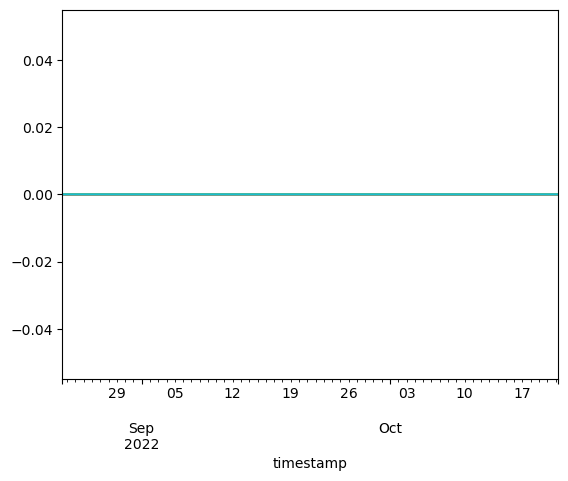

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


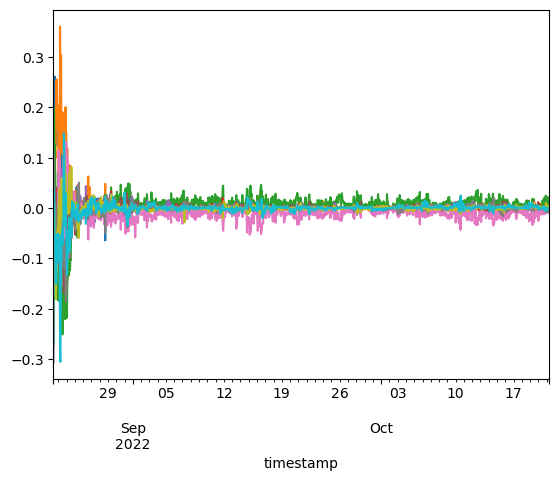

In [1]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd
import pandas_ta as ta

model = joblib.load('/home/jovyan/data/20221020_add_feat_nn.xz')
df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()